In [146]:
# Importing required packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import jax.numpy as jnp
from iminuit import Minuit 
from src.model import*
from src.model_test import*
from numpyro.infer import NUTS, MCMC
import jax
from src.model import*
from numpyro.infer import NUTS, MCMC
from src.plotting import*
import corner
from numpyro.infer import Predictive

In [147]:
# Importing data on Antikythera Mechanism (AM) as data_AM
data_AM = pd.read_csv("data/1-Fragment_C_Hole_Measurements.csv")

# Printing data
data_AM  

Section ID  Hole  Inter-hole Distance    Mean(X)   Mean(Y)
0            0     1                  NaN   15.59931  92.59653
1            1     2                  NaN   16.44167  91.50069
2            1     3             1.440694   17.30764  90.34931
3            1     4             1.456973   18.15278  89.16250
4            1     5             1.299821   18.96528  88.14792
..         ...   ...                  ...        ...       ...
76           7    77             1.259985  108.69444  63.42778
77           7    78             1.430105  110.05486  63.86875
78           7    79             1.179606  111.14583  64.31736
79           7    80             1.428043  112.48021  64.82604
80           7    81             1.259015  113.64028  65.31528

[81 rows x 5 columns]

In [148]:
sub_data = data_AM[~data_AM['Section ID'].isin([0,4])] # removing sections 0 and 4
sub_data.shape # Quick check

(79, 5)

HMC

In [149]:
hole_d, x_d, y_d = jnp.array(sub_data['Hole'].to_numpy()), jnp.array(sub_data['Mean(X)'].to_numpy()), jnp.array(sub_data['Mean(Y)'].to_numpy())

sec_id_sub = sub_data['Section ID'].to_numpy()
sec_mod = jnp.array([x-1 if x < 4 else x - 2 for x in sec_id_sub]) 

Radial-tangential

In [150]:
nuts_kernel_rt = NUTS(rad_tang_model_test)

mcmc_rt = MCMC(nuts_kernel_rt, num_samples=2000, num_warmup=1000)
rng_key = jax.random.key(0)
mcmc_rt.run(rng_key, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_rt = mcmc_rt.get_samples()

sample: 100%|██████████| 3000/3000 [02:56<00:00, 16.96it/s, 191 steps of size 1.02e-02. acc. prob=0.91] 


In [151]:
mcmc_rt.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            N    355.29      1.40    355.33    353.18    357.77    395.39      1.00
alpha_pred[0]     -2.54      0.00     -2.54     -2.55     -2.54    701.47      1.00
alpha_pred[1]     -2.54      0.00     -2.54     -2.55     -2.54    899.98      1.00
alpha_pred[2]     -2.54      0.00     -2.54     -2.55     -2.53    398.66      1.00
alpha_pred[3]     -2.56      0.02     -2.56     -2.59     -2.54   1265.74      1.00
alpha_pred[4]     -2.55      0.03     -2.55     -2.61     -2.50   1040.58      1.00
alpha_pred[5]     -2.58      0.01     -2.58     -2.59     -2.57    656.45      1.00
            r     77.35      0.29     77.36     76.87     77.79    377.51      1.00
      sigma_r      0.03      0.00      0.03      0.02      0.03   1728.44      1.00
      sigma_t      0.13      0.01      0.13      0.11      0.15   1688.45      1.00
  x_centre[0]     79.70      0.20     79.70     79.33     80.00    381.13  

In [152]:
N_rt_pred = jnp.mean(posterior_samples_rt['N'])
R_rt_pred = jnp.mean(posterior_samples_rt['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_rt = jnp.mean(posterior_samples_rt["alpha_pred"], axis=0)
xcents_opt_rt = jnp.mean(posterior_samples_rt["x_centre"], axis=0)
ycents_opt_rt = jnp.mean(posterior_samples_rt["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_rt = jnp.array([phases_opt_rt, xcents_opt_rt, ycents_opt_rt])

In [153]:
nuts_kernel_is = NUTS(isotropic_model_test)

mcmc_iso = MCMC(nuts_kernel_is, num_samples=2000, num_warmup=1000)
rng_key_iso = jax.random.key(0)
mcmc_iso.run(rng_key_iso, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_iso = mcmc_iso.get_samples()

sample: 100%|██████████| 3000/3000 [01:02<00:00, 47.85it/s, 351 steps of size 7.65e-03. acc. prob=0.90] 


In [154]:
N_is_pred = jnp.mean(posterior_samples_iso['N'])
R_is_pred = jnp.mean(posterior_samples_iso['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_iso = jnp.mean(posterior_samples_iso["alpha_pred"], axis=0)
xcents_opt_iso = jnp.mean(posterior_samples_iso["x_centre"], axis=0)
ycents_opt_iso = jnp.mean(posterior_samples_iso["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_iso = jnp.array([phases_opt_iso, xcents_opt_iso, ycents_opt_iso])

In [155]:
mcmc_iso.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            N    355.33      4.40    355.43    348.34    362.74    371.99      1.00
alpha_pred[0]     -2.54      0.00     -2.54     -2.55     -2.54    619.94      1.00
alpha_pred[1]     -2.54      0.01     -2.54     -2.56     -2.53    711.59      1.00
alpha_pred[2]     -2.54      0.01     -2.54     -2.56     -2.52    379.87      1.00
alpha_pred[3]     -2.56      0.05     -2.56     -2.64     -2.47   1039.43      1.00
alpha_pred[4]     -2.55      0.07     -2.55     -2.65     -2.43    822.97      1.00
alpha_pred[5]     -2.58      0.02     -2.58     -2.62     -2.54    536.54      1.00
            r     77.36      0.95     77.37     75.95     79.04    369.83      1.00
        sigma      0.09      0.01      0.09      0.09      0.10   1695.58      1.00
  x_centre[0]     79.70      0.68     79.70     78.70     80.88    388.07      1.00
  x_centre[1]     79.89      0.76     79.87     78.75     81.24    856.95  

In [156]:
# Computing hole predicted location using predicted parameters from Iminuit for:

# Radial-Tangential Model:
predicted_hole_loc_rt = hole_prediction(N_rt_pred, R_rt_pred, optimised_params_rt, sec_mod)

# Isotropic Model:
predicted_hole_loc_is = hole_prediction(N_is_pred, R_is_pred, optimised_params_iso, sec_mod)

In [157]:
# Constructiong Data Frame for:

# Radial-Tangential Model

d_rt = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_rt[0],
    'Mean(Y)' : predicted_hole_loc_rt[1]
}

pred_data_rt_HMC = pd.DataFrame(d_rt)

# Radial-Tangential Model

d_is = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_is[0],
    'Mean(Y)' : predicted_hole_loc_is[1]
}

pred_data_is_HMC = pd.DataFrame(d_is)

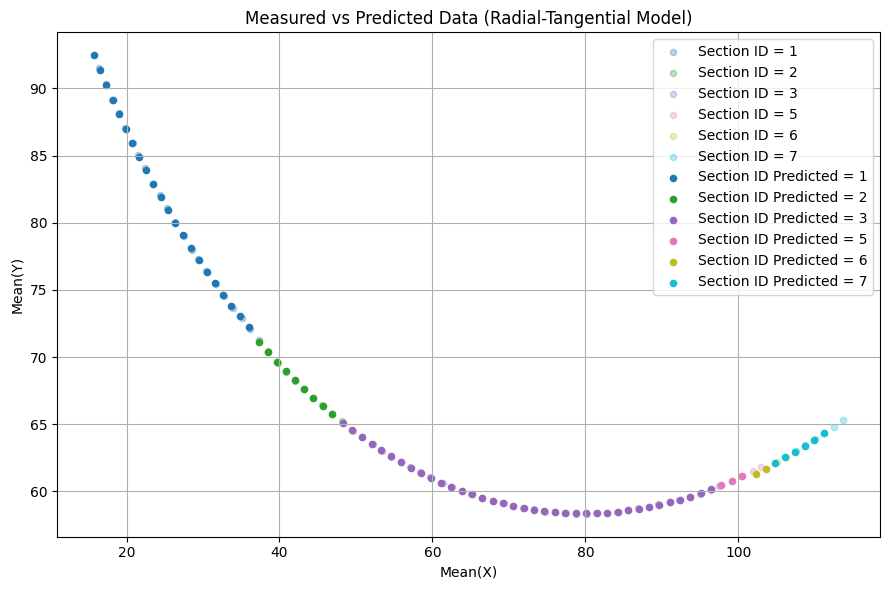

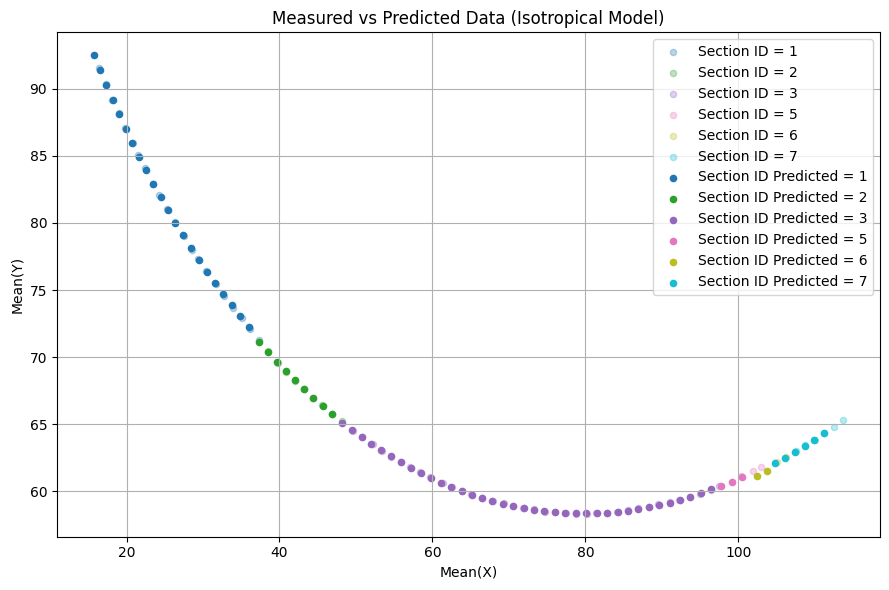

In [158]:
plotting_comparison(sub_data, pred_data_rt_HMC, 'Radial-Tangential Model')
plotting_comparison(sub_data, pred_data_is_HMC, 'Isotropical Model')

Trying to reproduce corner plots using `corner`

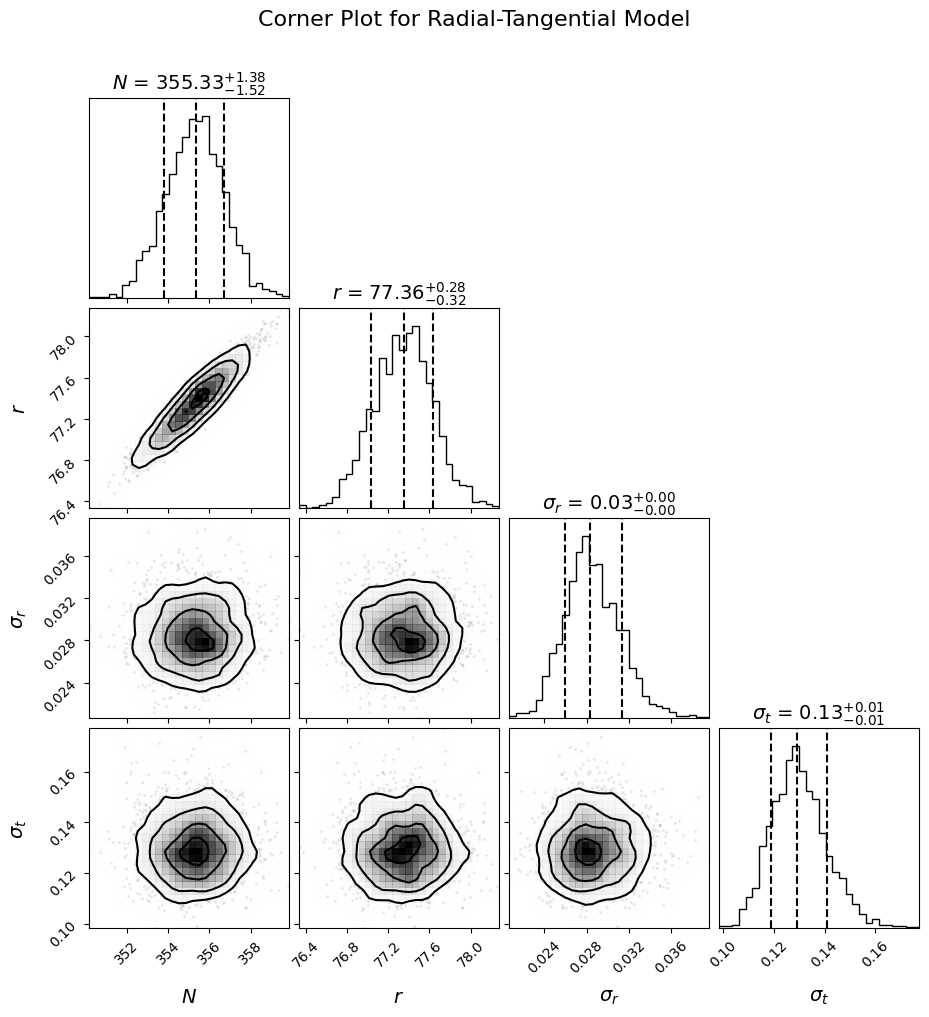

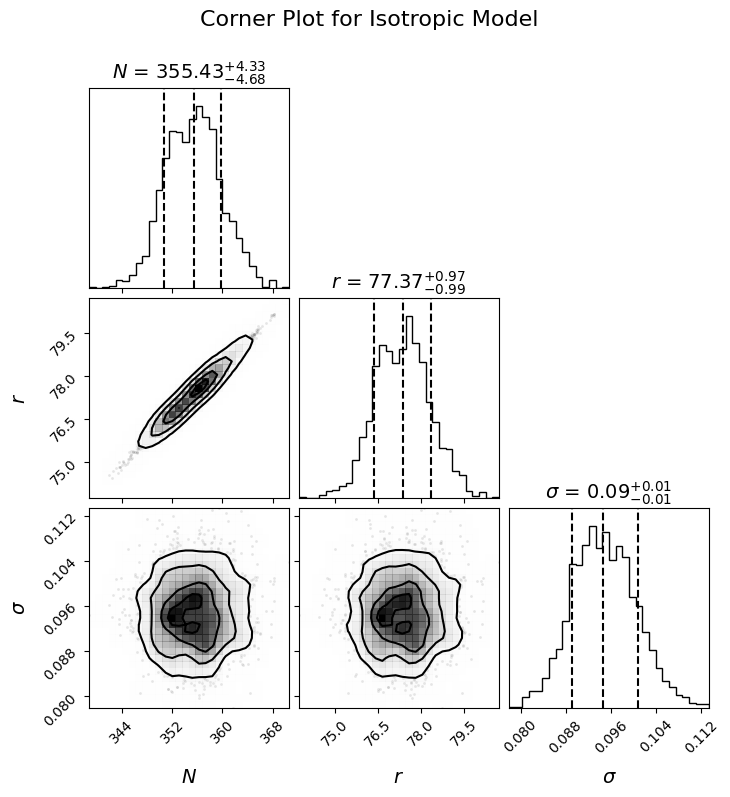

In [160]:
corner_plots(posterior_samples_iso, posterior_samples_rt)

Pick one of the holes, on your plot
of the measured hole locations, show the posterior predictive distribution for its hole
locations using both models.


In [161]:
# Generate posterior predictive samples (radial-tangential model)
predictive_rt = Predictive(rad_tang_model_test, posterior_samples=posterior_samples_rt)
posterior_predictive_samples_rt = predictive_rt(jax.random.key(1), sec_mod, hole_d)

# Generate posterior predictive samples (isotropic model)
predictive_is = Predictive(isotropic_model_test, posterior_samples_iso)
posterior_predictive_samples_is = predictive_is(jax.random.key(1), sec_mod, hole_d)



In [162]:
post_pred_sample_hole_rt = posterior_predictive_samples_rt['obs']
post_pred_sample_hole_is = posterior_predictive_samples_is['obs']
print('Shape posterior predictive sample generated from posterior samples generated from:')
print('- Radial tangential model,', post_pred_sample_hole_rt.shape)
print('- Isotropic model,', post_pred_sample_hole_is.shape)

Shape posterior predictive sample generated from posterior samples generated from:
- Radial tangential model, (2000, 79, 2)
- Isotropic model, (2000, 79, 2)


#### Posterior predictive distribution of a single point

In [163]:
# Define hole_index

hole_index = 69

# Extract posterior predictive samples for single hole

# Radial-Tangential Model
x_post_pred_rt = post_pred_sample_hole_rt[:, hole_index, 0]
y_post_pred_rt = post_pred_sample_hole_rt[:, hole_index, 1]

# Isotropic Model
x_post_pred_is = post_pred_sample_hole_is[:, hole_index, 0]
y_post_pred_is = post_pred_sample_hole_is[:, hole_index, 1]

In [164]:
print(np.unique(x_post_pred_is).shape)

(1956,)


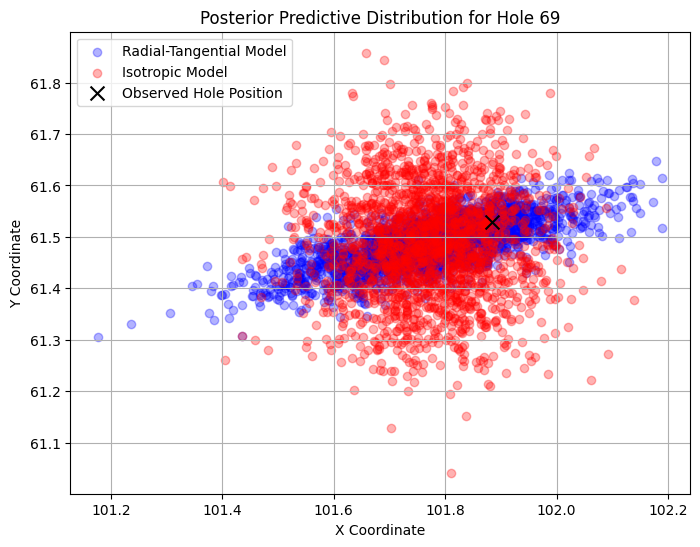

In [165]:
# Observed hole position
observed_x = x_d[hole_index]
observed_y = y_d[hole_index]

plt.figure(figsize=(8, 6))

# Plot posterior predictive samples
plt.scatter(x_post_pred_rt, y_post_pred_rt, alpha=0.3, color="blue", label="Radial-Tangential Model")
plt.scatter(x_post_pred_is, y_post_pred_is, alpha=0.3, color="red", label="Isotropic Model")

# Plot the actual observed hole position
plt.scatter(observed_x, observed_y, color="black", marker="x", s=100, label="Observed Hole Position")

# Labels and legend
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"Posterior Predictive Distribution for Hole {hole_index}")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [167]:
import seaborn as sns

Text(0.5, 1.0, 'Prior Predictive Distribution of Hole 69')

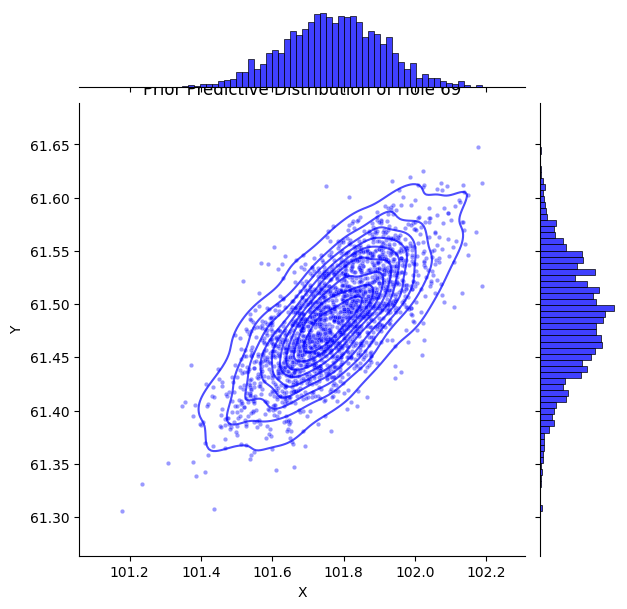

In [189]:
sns.jointplot(x = x_post_pred_rt, y = y_post_pred_rt, kind = 'scatter', s = 10, marginal_kws=dict(bins=60, fill=True), color = 'blue', alpha = 0.4)
sns.kdeplot(x = x_post_pred_rt, y = y_post_pred_rt, color = 'blue', alpha = 0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Prior Predictive Distribution of Hole {hole_index}')

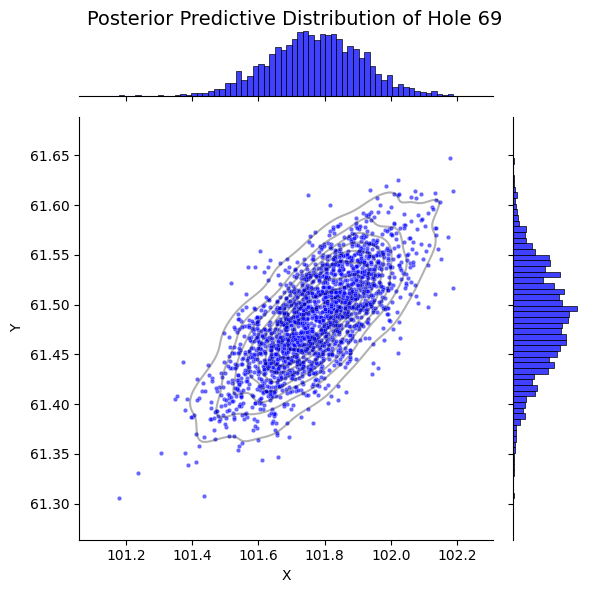

In [ ]:

# Create the jointplot object
g = sns.jointplot(
    x=x_post_pred_rt, 
    y=y_post_pred_rt, 
    kind='scatter', 
    s=10, 
    marginal_kws=dict(bins=60, fill=True), 
    color='blue', 
    alpha=0.6
)

# Add KDE contours
sns.kdeplot(
    x=x_post_pred_rt, 
    y=y_post_pred_rt, 
    ax=g.ax_joint, 
    color='black', 
    alpha=0.3
)

# Set axis labels
g.set_axis_labels("X", "Y")

# Add title to the whole figure, not the joint axes
g.figure.suptitle(f"Posterior Predictive Distribution of Hole {hole_index}", fontsize=14)

# Adjust spacing so the title doesn't overlap
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.95)  # push plot down to make space for title

plt.show()


In [200]:
def joint_plot_sns(x_prediction, y_prediction, hole_index, x_observed, y_observed, title_ajustment):

    x_obs = x_observed[hole_index]
    y_obs = y_observed[hole_index]

    # Create the jointplot object
    g = sns.jointplot(
        x=x_prediction, 
        y=y_prediction, 
        kind='scatter', 
        s=10, 
        marginal_kws=dict(bins=60, fill=True), 
        color='blue', 
        alpha=0.6
    )

    # Add KDE contours
    sns.kdeplot(
        x=x_prediction, 
        y=y_prediction, 
        ax=g.ax_joint, 
        color='black', 
        alpha=0.3
    )

    # Add observed hole location, and predicted mean

    plt.scatter(x_obs, y_obs, color = 'red', s = 20, label = f"Hole {hole_index} Location")
    plt.scatter(x_prediction.mean(), y_prediction.mean(), color = "red", marker = 'x', label = f"Hole {hole_index} Predictive Mean")

    # Set axis labels
    g.set_axis_labels("X", "Y")

    # Add title to the whole figure, not the joint axes
    g.figure.suptitle(f"Posterior Predictive Distribution of Hole {hole_index} ({title_ajustment})", fontsize=14)

    # Adjust spacing so the title doesn't overlap
    g.figure.tight_layout()
    g.figure.subplots_adjust(top=0.95)  # push plot down to make space for title

    plt.legend()

    plt.show()

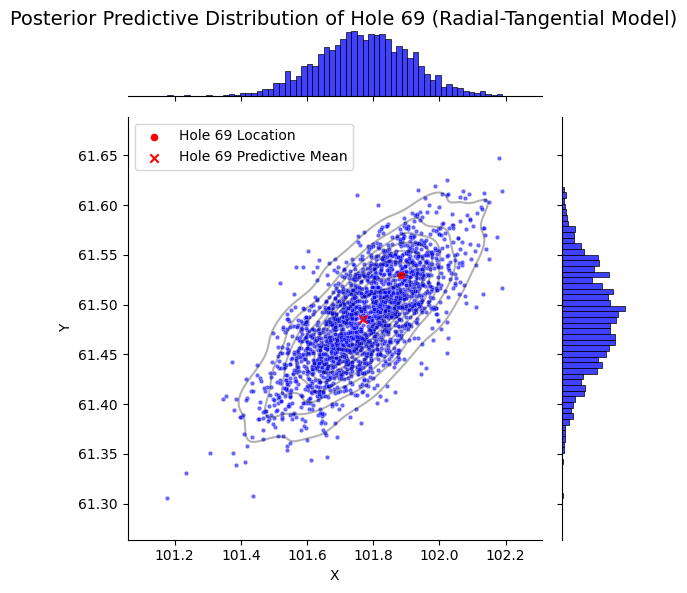

In [201]:
joint_plot_sns(x_post_pred_rt, y_post_pred_rt, hole_index, x_d, y_d, 'Radial-Tangential Model')

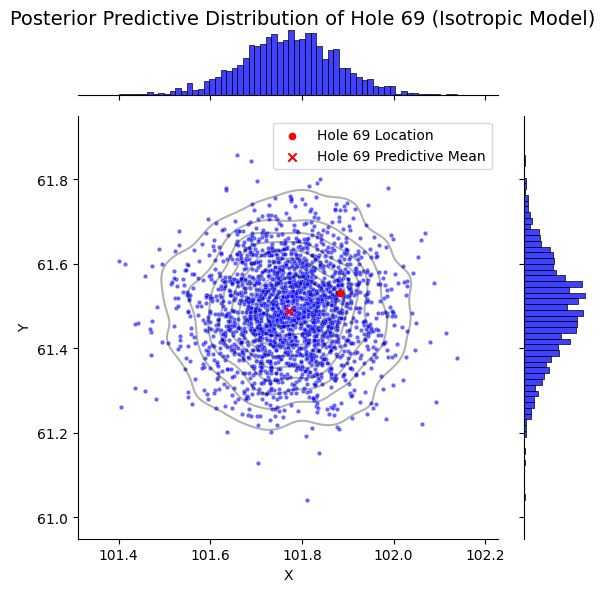

In [204]:
joint_plot_sns(x_post_pred_is, y_post_pred_is, hole_index, x_d, y_d, 'Isotropic Model')